In [1]:
from PIL import Image, ImageFilter, ImageDraw
import random
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from matplotlib.ticker import LinearLocator

### Utilities

In [2]:
# stacks two images side by side
def stackImages (image1, image2):
    aspectRatio2 = float(image2.size[0]) / float(image2.size[1])
    img1 = image1
    # adjust size of second image st img1.height = img2.height and aspect ratio stays the same 
    img2 = image2.resize((int(image1.size[1] * aspectRatio2), image1.size[1]))
    fin = Image.new(mode = 'RGB', size = (img1.size[0] + img2.size[0], image1.size[1]), color = (250,250,250))
    fin.paste(img1, (0, 0))
    fin.paste(img2, (img1.size[0], 0))
    return fin

In [3]:
# iterates over every image pixel
def iterateOverImage(image, due = lambda p, v, x, y : v, final = lambda v : v):
    value = 0
    pixels = image.load()
    for x in range(image.size[0]):
        for y in range(image.size[1]):
            # due changes value during the iteration
            value = due(pixels[x, y], value, x, y)
            
    # final makes final adjustments
    value = final(value)
    return value

In [4]:
# draws drones on a specified image
def drawDrones(image, positions):
    image_drawn = image.convert(mode = 'RGB').copy()
    draw = ImageDraw.Draw(image_drawn)
    
    for pos in positions:
        box = [(0,0), (0,0)]
        
        box[0] = (pos[0] - 29, pos[1] - 29)
        box[1] = (pos[0] + 29, pos[1] + 29)
        
        draw.ellipse(xy = box, outline = 250, width = 20, fill = (100,0,0))

    return image_drawn

In [5]:
def partial_derivative(function, X, indeces, delta, **args):
    result = 0
    deltaX = np.zeros(X.shape)
    deltaX[indeces] = 1
    result = float((function(X + delta * deltaX, *(args.values())) - function(X - delta * deltaX, *(args.values())))) / (2 * delta)
    return result

In [6]:
def gradient(function, X, delta = 0.001, **args):
    vector = np.ndarray(X.shape)
    
    for indeces, comp in np.ndenumerate(X):
        vector[indeces] = partial_derivative(function, X, indeces, delta, **args)
    return vector

### Problem Related Functions/Classes

In [7]:
def mod(val, centre):
    PW_MAX = 1000
    return (PW_MAX) * (val < centre) * (val - centre) ** 2 / centre ** 2 + \
        PW_MAX * (val >= centre) * (val - centre) ** 2 / (max-centre)**2

In [8]:
class SolvingAlgorithm(Enum):
    CLASSIC = 1
    ACCELERATED = 2
    STOCHASTIC = 3

In [9]:
def classic_gradient_descent_step(self):
    difference = self.ETA * gradient(function = self.COST_FUNCTION, X = self.positions.copy(), delta = self.DELTA, self = self)
    return - difference

In [10]:
def accelerated_gradient_descent_step(self):
    retained_momentum = self.ALPHA * self.prev_momentum
    momentum = - self.ETA * gradient(function = self.COST_FUNCTION, X = self.positions + retained_momentum, delta = self.DELTA, self = self)
    momentum += retained_momentum
    return momentum

In [11]:
def drone_weight(int_positions, pixels, average):
    total_weight = 0
    for pos in int_positions:
        total_weight += mod(pixels[pos[0], pos[1]], average)
    return total_weight

In [12]:
def drone_variance(int_positions, pixels, average):
    variance = 0
    drone_number = int_positions.shape[0]
    for pos in int_positions:
        pos = tuple(pos)
        variance += (pixels[pos] - average) ** 2
        
    variance /= drone_number
    return variance

In [13]:
def drone_average(int_positions, pixels):
    drone_average = 0
    drone_number = int_positions.shape[0]
    for pos in int_positions:
        pos = tuple(pos)
        drone_average += float(pixels[pos])
    
    drone_average /= drone_number
    return drone_average

In [14]:
def drone_fairness(int_positions, pixels):
    fairness = 0
    drone_number = int_positions.shape[0]
    norm = np.sqrt(pixels.shape[0] * pixels.shape[1])
    
    for pos1 in int_positions:
        pos1 = tuple(pos1)
        
        for pos2 in int_positions:
            pos2 = tuple(pos2)
            
            distance = np.sqrt((pos1[0] - pos2[0] ) ** 2 + (pos1[1] - pos2[1]) ** 2)
            
            if distance != 0:
                fairness += norm / distance
            
    fairness /= drone_number
    return fairness

In [15]:
def drone_exclusion(int_positions, pixels):
    result = 0
    drone_number = int_positions.shape[0]
    norm = np.sqrt(pixels.shape[0] * pixels.shape[1])
    
    for pos1 in int_positions:
        pos1 = tuple(pos1)
        for pos2 in int_positions:
            pos2 = tuple(pos2)

            value_distance = np.sqrt(((pos1[0] - pos2[0])/MAP_DIAGONAL) ** 2 + ((pos1[1] - pos2[1])/MAP_DIAGONAL) ** 2 
            + 800 * ((float(pixels[pos1]) - float(pixels[pos2])) / 255.) **2 )
            
            if value_distance != 0:
                result += 1 / value_distance ** 1 

    result /= drone_number
    return result

In [16]:
def total_distance(positions):
    result = 0
    drone_number = positions.shape[0]
    
    for pos in positions:
        pos = tuple(pos)

        result += np.sqrt(pos[0]**2 + pos[1]**2)
    return result

### Loading and Modifying Images

In [17]:
image = Image.open('../data/images/mediterranian.jpg')
image = image.convert(mode = 'L')
IMAGE_SIZE = image.size
print(IMAGE_SIZE)

(2422, 1938)


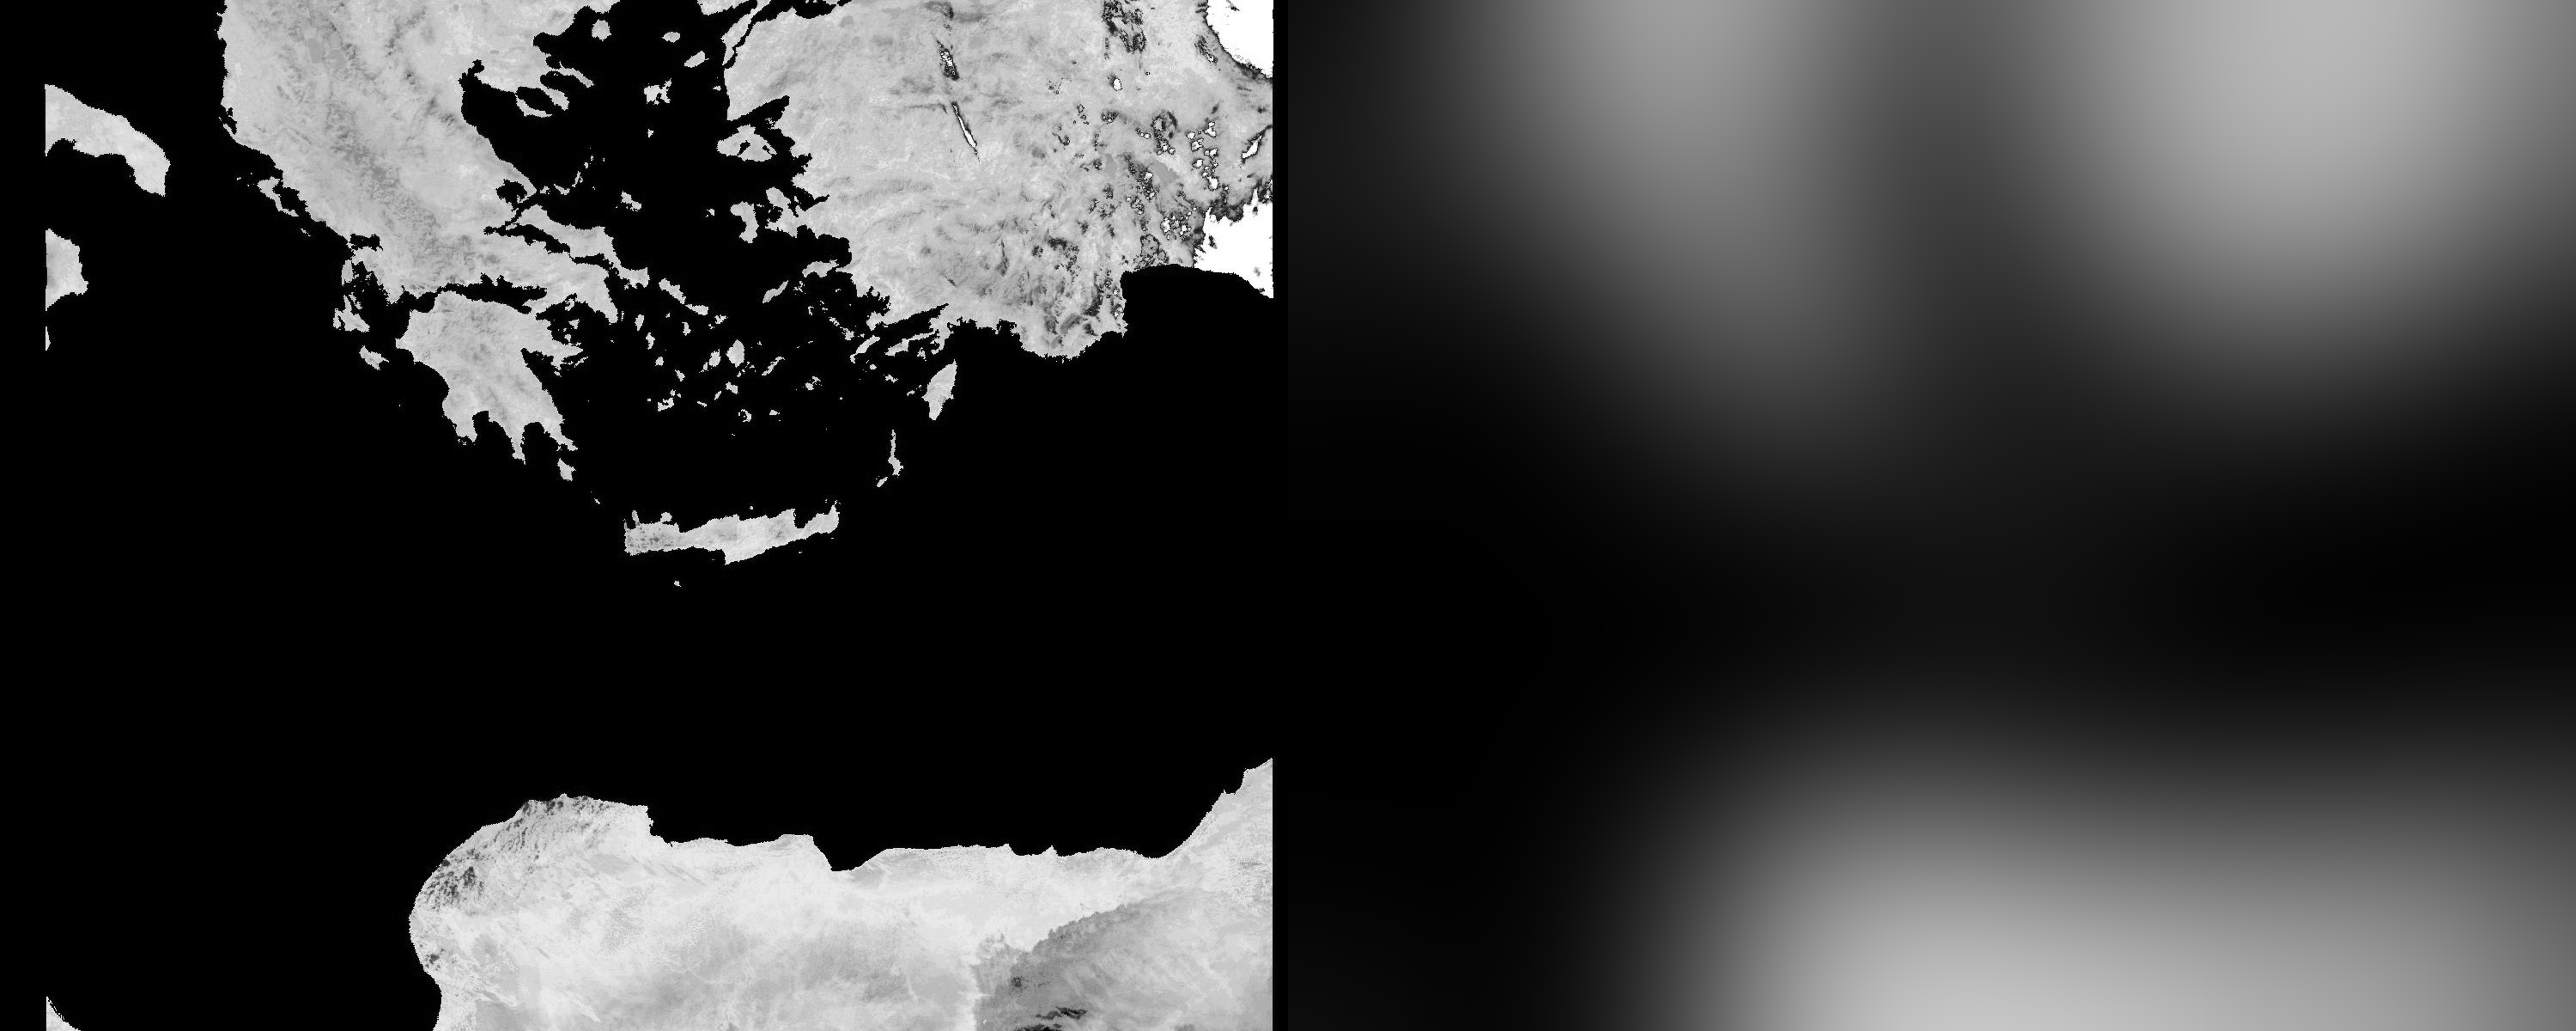

(2422, 1938)
3101.9232743573784


In [18]:
image_modified = image.filter(ImageFilter.GaussianBlur(200))
display(stackImages(image, image_modified))

ARRAY_IMAGE_PIXELS = np.array(image).T
ARRAY_IMAGE_MODIFIED_PIXELS =  np.array(image_modified).T
print(ARRAY_IMAGE_MODIFIED_PIXELS.shape)
MAP_DIAGONAL = np.sqrt(ARRAY_IMAGE_MODIFIED_PIXELS.shape[0]**2+ARRAY_IMAGE_MODIFIED_PIXELS.shape[1]**2)
print(MAP_DIAGONAL)

In [19]:
DRONE_NUMBER = 5
img_avg = iterateOverImage(image, lambda p, v, x, y : p + v, lambda v : v / (image.size[0] * image.size[1]))
img_mod_avg = iterateOverImage(image_modified, lambda p, v, x, y : p + v, lambda v : v / (image_modified.size[0] * image_modified.size[1]))

print(img_avg, img_mod_avg)


64.3080697749133 62.35278927512593


### Initial Position Presets

In [20]:
# Intial Positions Presets:
_POSITION_PRESET_TYPE_O = np.array([
    [1340, 950],
    [1200, 1090],
    [1340, 1090],
    [1060, 950],
    [1060, 1090]
], dtype = 'float')

_POSITION_PRESET_TYPE_I = np.array([
    [1150, 1700],
    [1150, 1250],
    [1850, 1050],
    [350, 1250],
    [2000, 300]
], dtype = 'float')

_POSITION_PRESET_TYPE_II = np.array([
    [700, 300],
    [1150, 1250],
    [1850, 1050],
    [350, 1250],
    [2000, 300]
], dtype = 'float')

_POSITION_PRESET_TYPE_III = np.array([
    [1000, 1700],
    [650, 1050],
    [1850, 1050],
    [350, 1250],
    [1600, 1800]
], dtype = 'float')

_POSITION_PRESET_TYPE_IV = np.array([
    [2100, 200],
    [650, 1050],
    [1850, 1050],
    [350, 1250],
    [2050, 1800]
], dtype = 'float')

_POSITION_PRESET_TYPE_V = np.array([
    [2100, 100],
    [650, 1050],
    [1850, 1050],
    [350, 1250],
    [1750, 300]
], dtype = 'float')

_POSITION_PRESET_TYPE_VI = np.array([
    [1150, 1700],
    [650, 1050],
    [1850, 1050],
    [350, 1250],
    [2050, 1800]
], dtype = 'float')

_POSITION_PRESET_TYPE_VII = np.array([
    [1150, 1700],
    [1150, 1250],
    [1850, 1050],
    [350, 1250],
    [600, 300]
], dtype = 'float')

_POSITION_PRESET_TYPE_VIII = np.array([
    [2050, 1700],
    [1150, 1250],
    [1850, 1050],
    [350, 1250],
    [600, 300]
], dtype = 'float')

_POSITION_PRESET_TYPE_IX = np.array([
    [1000, 1700],
    [650, 1050],
    [1850, 1050],
    [2050, 1800],
    [1600, 1800]
], dtype = 'float')

_POSITION_PRESET_TYPE_X = np.array([
    [1150, 1200],
    [600, 300],
    [1850, 1050],
    [350, 1250],
    [800, 500]
], dtype = 'float')

_POSITION_PRESET_TYPE_XI = np.array([
    [1150, 1700],
    [600, 300],
    [1850, 1050],
    [350, 1250],
    [2000, 300]
], dtype = 'float')


### Initialization of Problem

In [68]:
def cost (X, self):
    # factors: 
    average_diff = 0
    variance = 0
    fairness = 0
    exclusion = 0
    square_border_distance = 0
    
    X = np.array(X, dtype = 'int32')
    
    # average
    _drone_average = drone_average(X, self.IMG_REFERENCE)
    average_diff = (self.image_average - _drone_average - 1) ** 2

    # variance
    variance = drone_variance(X, self.IMG_REFERENCE, _drone_average)

    # distance factor
    fairness = drone_fairness(X, self.IMG_REFERENCE)
    
    # exclusion
    exclusion = drone_exclusion(X, self.IMG_REFERENCE)
    
    # Avoid Boundary
    for pos in X:
        square_border_distance += np.sqrt(self.img_shape[0] * self.img_shape[1]) / \
        np.min(np.abs([pos[0], pos[1], pos[0] - self.img_shape[0], pos[1] - self.img_shape[1]]))
    square_border_distance /= self.DRONE_NUMBER ** 0.5
    
    result = self.COST_HYPERPARAMS[0] * average_diff ** self.COST_HYPERPARAMS[1] \
        - self.COST_HYPERPARAMS[2] * (0.5 * variance) ** self.COST_HYPERPARAMS[3] \
        + self.COST_HYPERPARAMS[4] * fairness ** self.COST_HYPERPARAMS[5] \
        + self.COST_HYPERPARAMS[6] * square_border_distance ** self.COST_HYPERPARAMS[7]

    result += self.COST_HYPERPARAMS[8] * exclusion ** self.COST_HYPERPARAMS[9]
    
    return result

In [69]:
def initialization(self, algorithm, epsilon):
    initialize_positions(self)
    self.int_positions = np.array(self.positions, dtype = 'int32')
    self.EPSILON = epsilon
    
    self.SOLVING_ALGORITHM = algorithm
    
    self.curr_epoch = 0
    self.prev_momentum = np.zeros(shape = self.positions.shape)
    self.prev_positions = self.positions.copy()
    
    # initialize diagrams
    self.diagram_size = int(self.MAX_EPOCH * self.DIAGRAM_DENSITY)
    self.cost_log = np.ndarray(self.diagram_size)
    self.distance_log =  np.ndarray(self.diagram_size)
    self.drone_distance_log = np.ndarray((self.DRONE_NUMBER, self.diagram_size))
    self.average_log =  np.ndarray(self.diagram_size)

### Solving the Problem

In [70]:
def solve(self):
    for self.curr_epoch in range(self.MAX_EPOCH):
        self.int_positions = np.array(self.positions, dtype = 'int32')
        
        if self.SOLVING_ALGORITHM == SolvingAlgorithm.CLASSIC:
            # Classic Gradient Descent
            self.positions += classic_gradient_descent_step(self)
            
        elif self.SOLVING_ALGORITHM == SolvingAlgorithm.ACCELERATED:
            # Acceletated/Nesterov's Gradient Descent
            momentum = accelerated_gradient_descent_step(self)
            self.positions += momentum
            self.prev_momentum = momentum
        
        elif self.SOLVING_ALGORITHM == SolvingAlgorithm.STOCHASTIC:
            print("Stochastic gradient descent is not implemented yet")
            pass
            
        temp_cost = self.COST_FUNCTION(self.positions, self)   
        
        # Show Image
        if self.curr_epoch % self.display_epoch_period == 0:
            temp_image = drawDrones(image_modified, self.positions).resize((int(image.size[0]/10), int(image.size[1]/10)))
            if self.display_images:
                display(temp_image)
                print(temp_cost)
            
            #Saving GIF
            if self.save_images:
                temp_image.save('../images/GIF_' + str(int(self.curr_epoch / self.display_epoch_period)) + '.png')
            
        #constructing diagrams / and convergence
        if self.curr_epoch % int(1 / self.DIAGRAM_DENSITY) == 0:
            temp_idx = int(self.curr_epoch * self.DIAGRAM_DENSITY)
        
            #cost over time
            self.cost_log[temp_idx] = temp_cost
        
            # convergence criteria
            if temp_idx > 1:
                #distance difference over time
                self.distance_log[temp_idx - 1] = total_distance(self.positions - self.prev_positions)
                for dr in range(self.DRONE_NUMBER):
                    p = self.positions[dr]
                    pv_p = self.prev_positions[dr]
                    self.drone_distance_log[dr, temp_idx - 1] = np.sqrt((p[0]-pv_p[0])**2 + (p[1]-pv_p[1])**2)
                    
                # convergence criteria
                if abs(self.cost_log[temp_idx] - self.cost_log[temp_idx - 1]) * self.DIAGRAM_DENSITY < self.EPSILON:
                    break
                    
            self.prev_positions = self.positions.copy()
        
    self.final_epoch = self.curr_epoch

In [71]:
# Summary
def print_summary(self):
    self.int_positions = np.array(self.positions, dtype = 'int32')
    self._drone_average = drone_average(self.int_positions, self.IMG_REFERENCE)
    self._drone_variance = drone_variance(self.int_positions, self.IMG_REFERENCE, self._drone_average)
    self._drone_fairness = drone_fairness(self.int_positions, self.IMG_REFERENCE)
    
    if self.display_images:
        print("                       Summary ")
        print("\n----------------------[FACTORS]-----------------------\n")
        print("DRONE AVERAGE, IMAGE AVERAGE: ", _drone_average, ", ", img_avg)
        print("STANDARD DEVIATION: ", np.sqrt(_drone_variance))
        print("FAIRNESS: ", _drone_fairness)
        print("\n---------------[DESCENT ALGORITHM INFO]---------------\n")
        if self.SOLVING_ALGORITHM == SolvingAlgorithm.CLASSIC:
            print("ALGORITHM: 'Classic Gradient Descent' ")
        elif self.SOLVING_ALGORITHM == SolvingAlgorithm.ACCELERATED:
            print("ALGORITHM: 'Nestorov's Momentum (Accelerated) Gradient Descent' ")
        print("FINAL EPOCH:", self.final_epoch)
        print("FINAL COST:", self.COST_FUNCTION(self.positions, self))
        print("\n----------------------[RESULT]------------------------\n")
        print("INITIAL POSITIONS: ")
        print(self.INITIAL_POSITIONS)
        print("\nFINAL POSITIONS: ")
        print(self.positions)
        
        drones_blurred = drawDrones(image_modified, self.positions).resize((int(image.size[0]/5), int(image.size[1]/5)))
        drones_original = drawDrones(image, self.positions).resize((int(image.size[0]/5), int(image.size[1]/5)))
        display(stackImages(drones_blurred, drones_original))

In [72]:
def print_diagrams(self):
    self.diagram_size = int(self.final_epoch * self.DIAGRAM_DENSITY)
        
    self.cost_log = self.cost_log[0:self.diagram_size]
    self.distance_log  = self.distance_log [0:self.diagram_size]
    self.drone_distance_log = np.array(self.drone_distance_log[0:self.DRONE_NUMBER, 0:self.diagram_size])

    if self.display_images:
        x = np.linspace(0, self.final_epoch, self.diagram_size)
        
        fig, ax = plt.subplots()
        if self.SOLVING_ALGORITHM == SolvingAlgorithm.CLASSIC: 
            plt.title("Classic Gradient Descent")
        elif self.SOLVING_ALGORITHM == SolvingAlgorithm.ACCELERATED: 
            plt.title("Nesterov's Gradient Descent")
        
        plt.xlabel("Epochs")
        plt.ylabel("Cost")
        
        ax.plot(x, self.cost_log, linewidth = 2.0)
        
        plt.show()
        
        fig, ax = plt.subplots()
        if self.SOLVING_ALGORITHM == SolvingAlgorithm.CLASSIC: 
            plt.title("Classic Gradient Descent")
        elif self.SOLVING_ALGORITHM == SolvingAlgorithm.ACCELERATED: 
            plt.title("Nesterov's Gradient Descent")
        
        plt.xlabel("Epochs")
        plt.ylabel("Derivative of total distance coverage")
        
        ax.plot(x, self.distance_log, linewidth = 2.0)
        for dr in range(self.DRONE_NUMBER):
            ax.plot(x, self.drone_distance_log[dr], linewidth = 2.0)
        plt.show()

In [73]:
def initialize_positions(self):
    MIN_DISTANCE_FROM_BORDER = 600
    for i in range(self.DRONE_NUMBER): # Generating Random Positions
        
        self.positions[i, 0], self.positions[i, 1]  = random.randint(MIN_DISTANCE_FROM_BORDER, self.IMG_REFERENCE.shape[0] - MIN_DISTANCE_FROM_BORDER), \
        random.randint(MIN_DISTANCE_FROM_BORDER, self.IMG_REFERENCE.shape[1] - MIN_DISTANCE_FROM_BORDER)
        
    self.positions = _POSITION_PRESET_TYPE_O.copy() # Using a predefined initial position
    #self.INITIAL_POSITIONS = self.positions.copy()
    if self.display_images:
        display(drawDrones(image, self.positions).resize((int(image.size[0] / 5), int(image.size[1] / 5))))
        print(self.positions)

In [74]:
def run_simulation(self, algorithm, epsilon):
    initialization(self, algorithm, epsilon)
    solve(self)
    print_summary(self)
    print_diagrams(self)

In [75]:
class Solver:
    #Variables:
    INITIAL_POSITIONS = None
    img_shape = (0,0)
    
    # Methods:
    _cost = cost
    _initialize_positions = initialize_positions
    _initialization = initialization
    _solve = solve
    _print_summary = print_summary
    _print_diagrams = print_diagrams
    _run_simulation = run_simulation
    _classic_gradient_descent_step = classic_gradient_descent_step
    _accelerated_gradient_descent_step = accelerated_gradient_descent_step

    # Constructors:
    def __init__(self, drone_number, image_pixels, image_average):
        self.DRONE_NUMBER = drone_number
        self.IMG_REFERENCE = image_pixels
        self.COST_HYPERPARAMS = (10,1,40,0.5,2,2,2,2,0,0)
        self.SOLVING_ALGORITHM = None
        self.ETA = 0.01
        self.DELTA = 20
        self.ALPHA = 0.9
        self.EPSILON = 0
        self.COST_FUNCTION = cost 
        self.MAX_EPOCH = 80000
        self.DIAGRAM_DENSITY = 1./5
        
        self.curr_epoch = 0
        self.positions = np.zeros(shape = (self.DRONE_NUMBER, 2))
        self.prev_momentum = np.zeros(shape = self.positions.shape)
        self.int_positions = np.array(self.positions, dtype = 'int32')
        self.img_shape = self.IMG_REFERENCE.shape
        self.image_average = image_average
        self.display_epoch_period = 500
        self.save_images = False
        self.display_images = True

In [76]:
solver = Solver(5, ARRAY_IMAGE_MODIFIED_PIXELS, img_mod_avg)

accelerated_distance_diagrams = [[],[],[],[],[]]
accelerated_cost_diagrams = []
accelerated_avg_diagrams = []
accelerated_sd_diagrams = []
accelerated_fr_diagrams = []
accelerated_fc_diagrams = []

classic_cost_diagrams = []
classic_distance_diagrams = [[],[],[],[],[]]
classic_avg_diagrams = []
classic_sd_diagrams = []
classic_fr_diagrams = []
classic_fc_diagrams = []

In [77]:
##for i in range(1):
##    print(i)
##    solver._run_simulation(SolvingAlgorithm.ACCELERATED, 0.000001)
##    for dr in range(solver.DRONE_NUMBER):
##        accelerated_distance_diagrams[dr].append(solver.drone_distance_log[dr])
##    accelerated_cost_diagrams.append(solver.cost_log)
##    
##    solver._run_simulation(SolvingAlgorithm.CLASSIC, 0.000001)
##    for dr in range(solver.DRONE_NUMBER):
##        classic_distance_diagrams[dr].append(solver.drone_distance_log[dr])
##    classic_cost_diagrams.append(solver.cost_log)
    

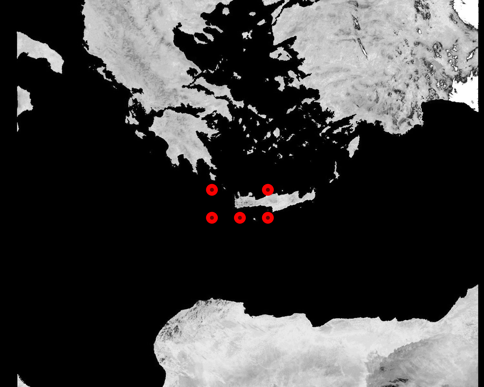

[[1340.  950.]
 [1200. 1090.]
 [1340. 1090.]
 [1060.  950.]
 [1060. 1090.]]


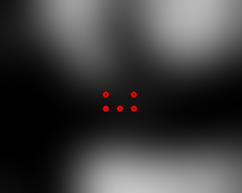

21760.943053574974


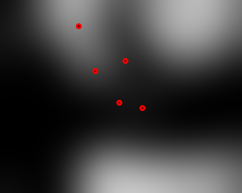

-100.62780389927289


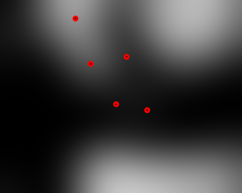

-592.0141735058305


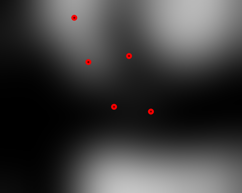

-684.2493549469621


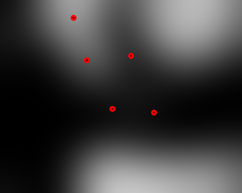

-742.1052288910867


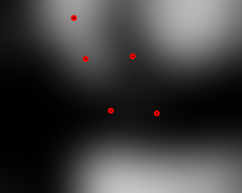

-780.1096646690091


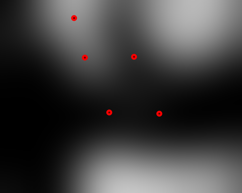

-815.5507093994332


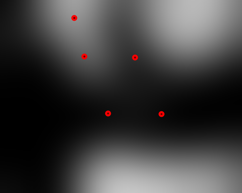

-836.3208609375794


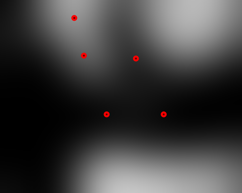

-859.9500133719157


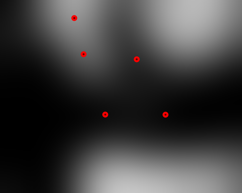

-876.2395801161974


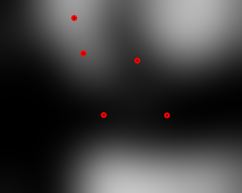

-886.6132805374045


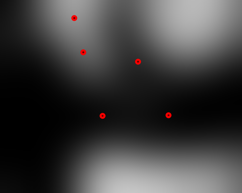

-903.9267729183423


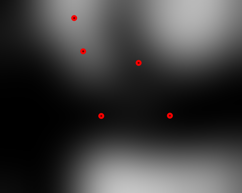

-917.2985423303315


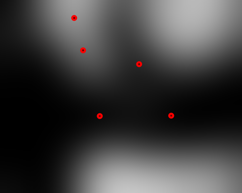

-929.1044186151779


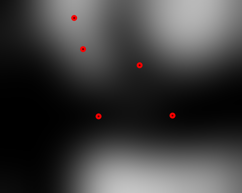

-944.3306609126296


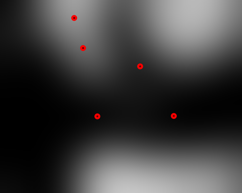

-954.9614979179645


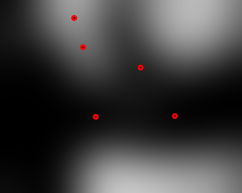

-967.0232062941927


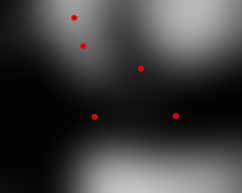

-979.0340464773853


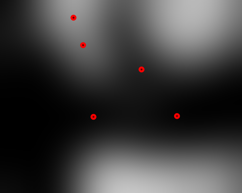

-982.8199375370564


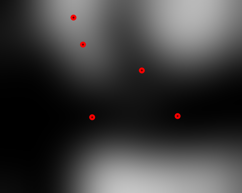

-988.4824552757393


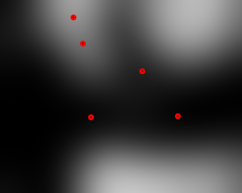

-1001.8522310337853


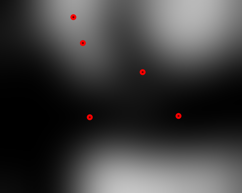

-1008.6014761559492


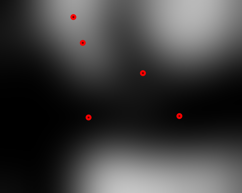

-1016.550965901843


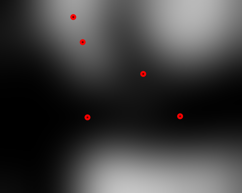

-1024.4224244173465


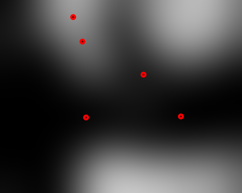

-1028.2885088332332


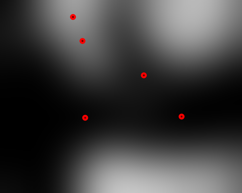

-1035.8487978168328


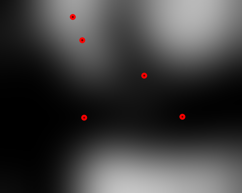

-1039.7520069921184


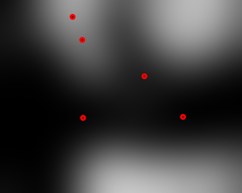

-1046.2442727852208


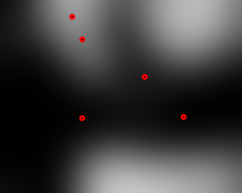

-1045.2106997560973


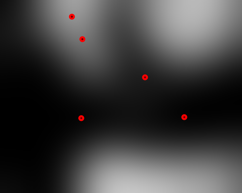

-1056.181478926069


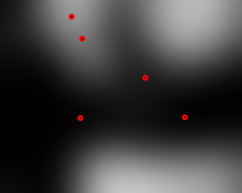

-1053.443311574213


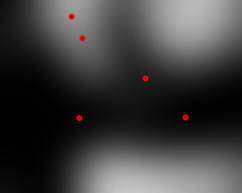

-1060.1177646153224


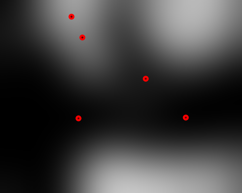

-1053.2555495524684


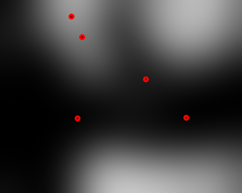

-1052.982445414289


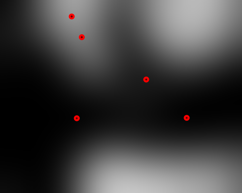

-1061.7738383235494


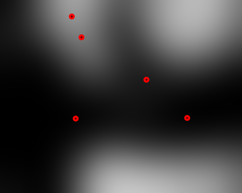

-1063.0081793802553


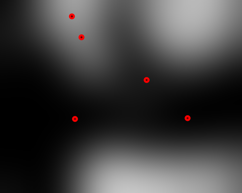

-1063.2674527884096


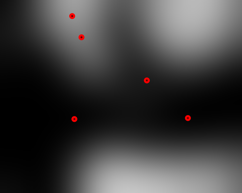

-1059.5504268559785


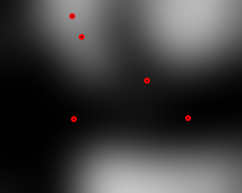

-1068.4451787194016


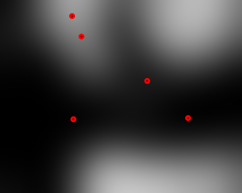

-1064.463715318788


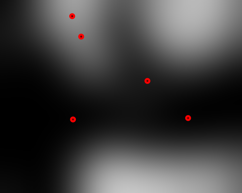

-1064.6612702200034


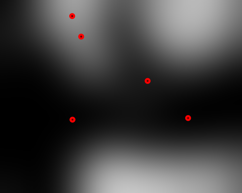

-1063.8965576152832


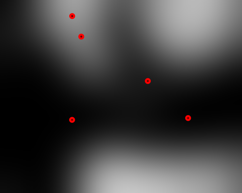

-1064.484151153785


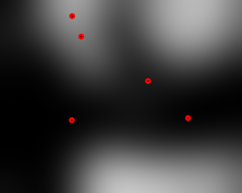

-1064.6351398276624


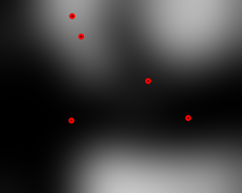

-1066.2014410885004


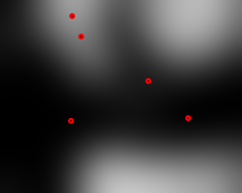

-1065.6246114609653


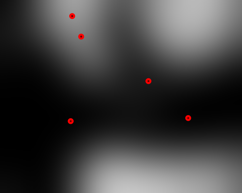

-1065.8750107668966


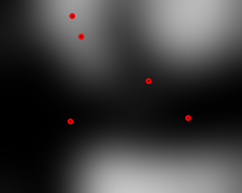

-1077.8101569073215


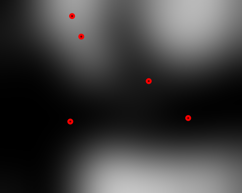

-1067.0318829271805


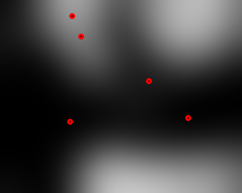

-1066.643205434106


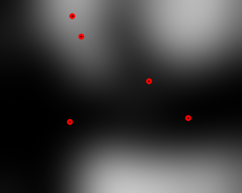

-1078.5125846309372


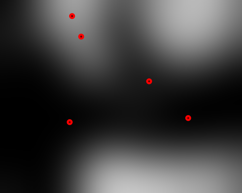

-1067.4995903143513


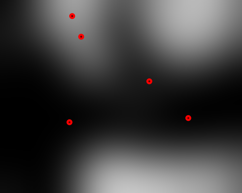

-1068.2692813133945


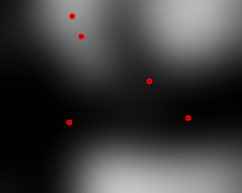

-1068.554862812218


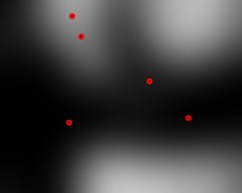

-1067.6677844255762


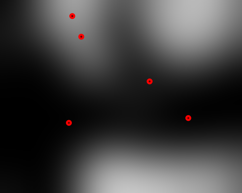

-1079.4501299484682


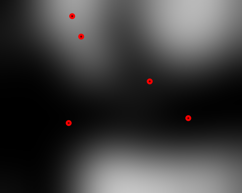

-1069.3168017728428


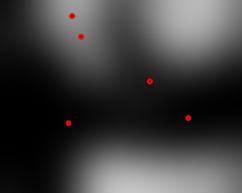

-1069.2014703822174


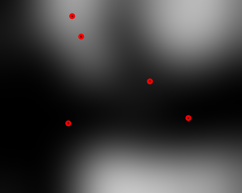

-1069.4654794114456


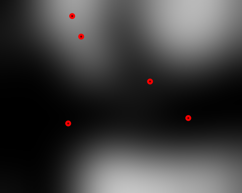

-1068.485003035737


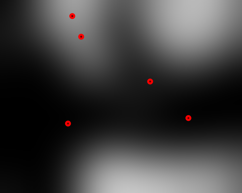

-1079.854677662858


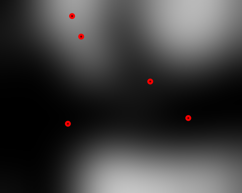

-1069.1483611632448


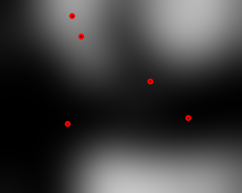

-1069.2266249270524


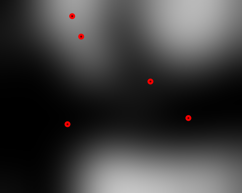

-1070.347820466296


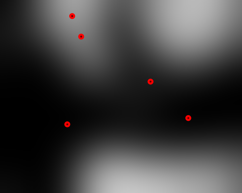

-1069.3172680440084


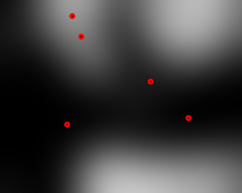

-1081.0458951142682


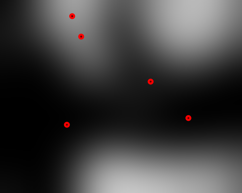

-1070.7442951461494


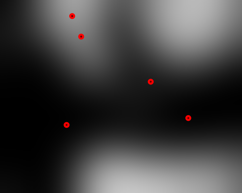

-1069.772973489432


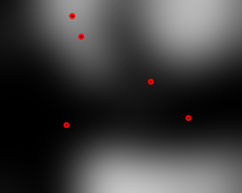

-1081.4898262113065


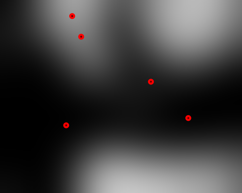

-1071.1112613747405


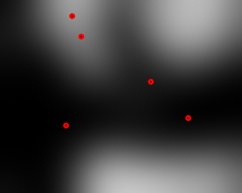

-1070.5344575177862


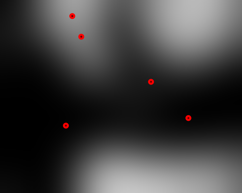

-1081.866293576683


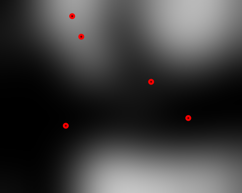

-1072.8065253623427


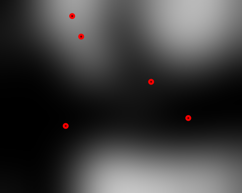

-1070.5539460363639


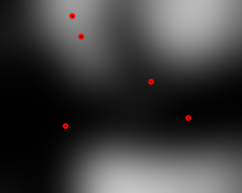

-1082.198452141722


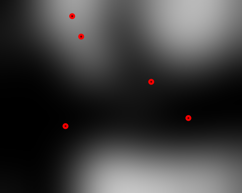

-1071.8074960960191


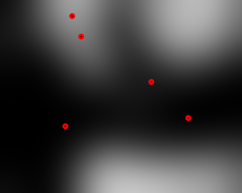

-1070.7693503391858


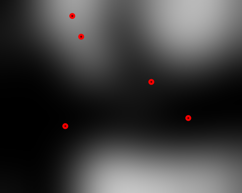

-1080.7686867611017


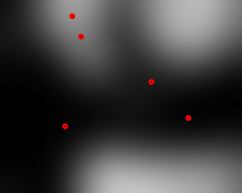

-1083.2224889659014


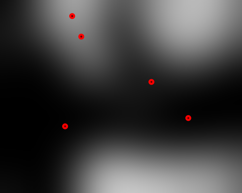

-1071.0236683433773


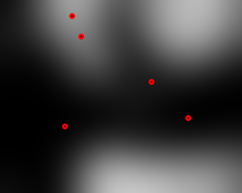

-1071.0918039942649


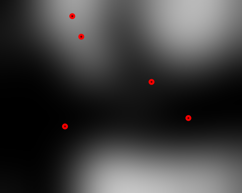

-1083.5166349405206


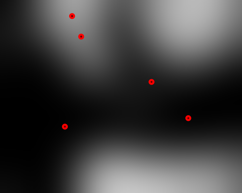

-1071.4852382089189


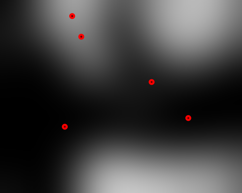

-1072.3473625987863


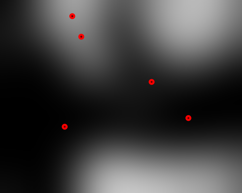

-1083.7017446582877


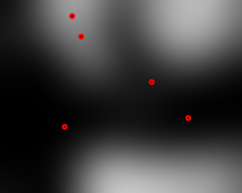

-1071.1172155490553


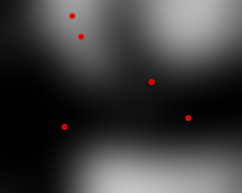

-1081.5666817640456


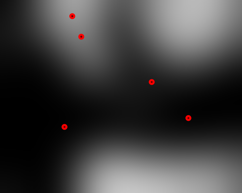

-1083.8258530334122


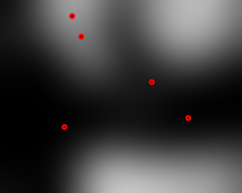

-1072.5293311544433


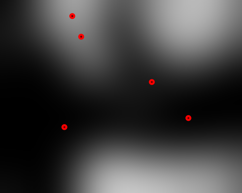

-1082.59098845271


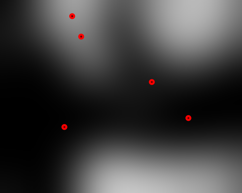

-1072.310473047479


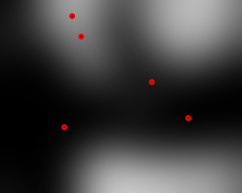

-1071.344333005101


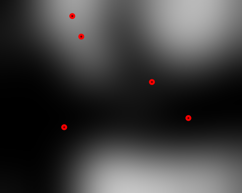

-1081.8366281945646


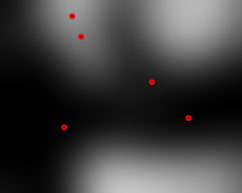

-1072.5263826413932


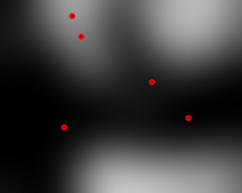

-1071.7259012917807


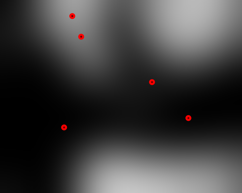

-1082.7624313235226


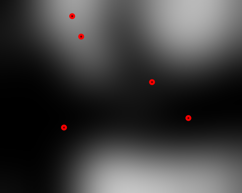

-1072.6373322473871


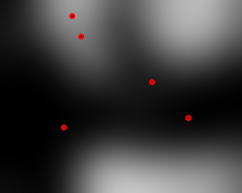

-1071.4623446368748


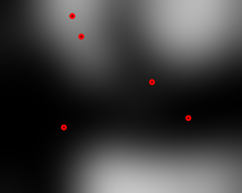

-1081.8976740903906


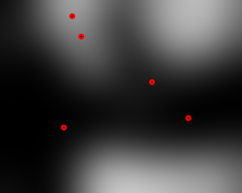

-1072.861624971949


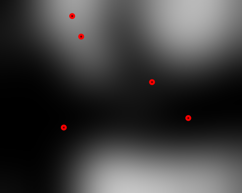

-1071.4120619664832


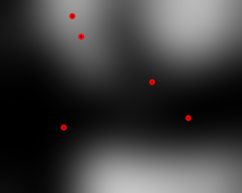

-1084.120165997655


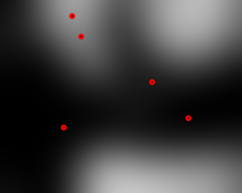

-1071.549869845388


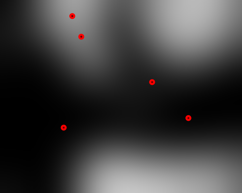

-1083.0305584057714


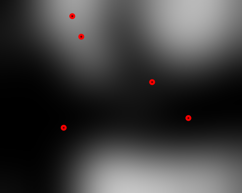

-1084.2707185009272


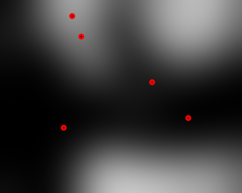

-1071.8351142639553


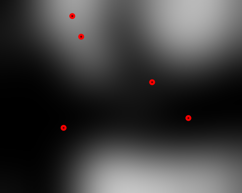

-1082.9168922818826


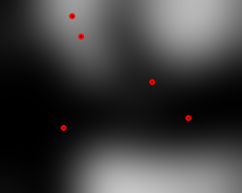

-1072.8444465624057


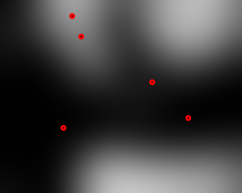

-1071.6643541749027


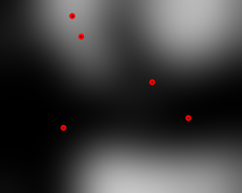

-1083.1309225702648


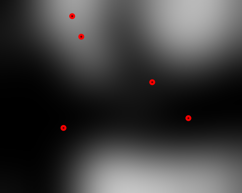

-1074.2307641290754


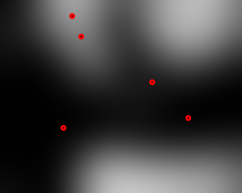

-1071.6643541749027


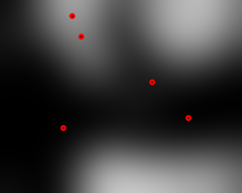

-1083.2774056300937


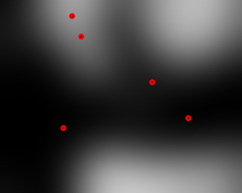

-1072.483072747938


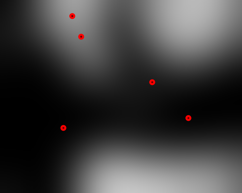

-1082.9146996062018


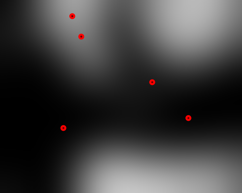

-1083.3845482549568


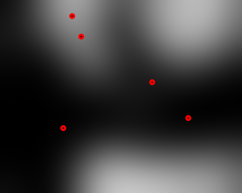

-1071.7573954200093


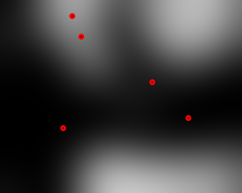

-1083.2718199619637


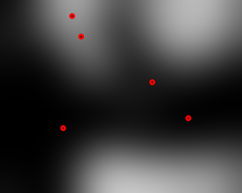

-1071.8321056168927


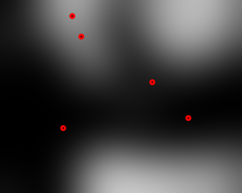

-1082.24249335406


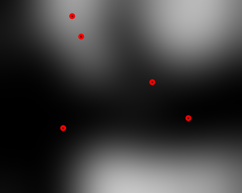

-1072.970086542807


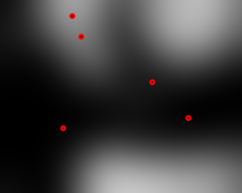

-1083.3706917556765


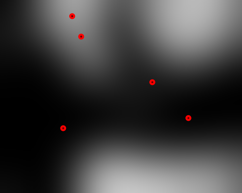

-1072.9345010526786


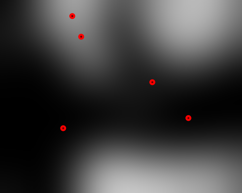

-1083.107510802998


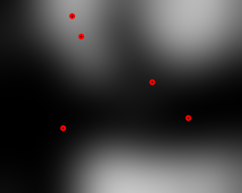

-1073.2081401835312


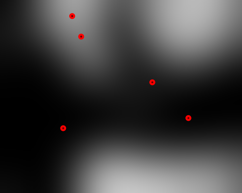

-1071.4780926424376


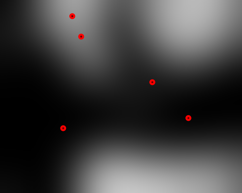

-1083.2072359939793


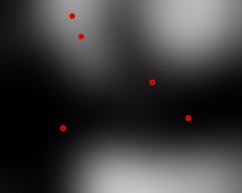

-1071.876570782977


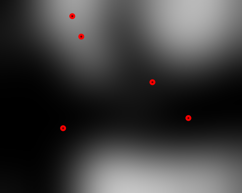

-1083.4269134982549


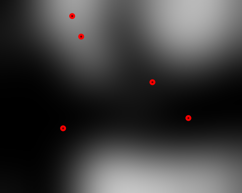

-1071.8421722890644


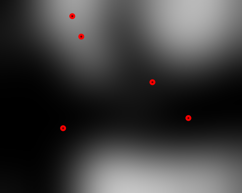

-1083.4269134982549


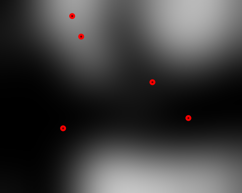

-1071.8421722890644


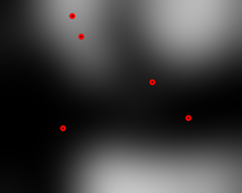

-1083.4165999260536


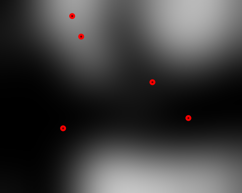

-1071.8421722890644


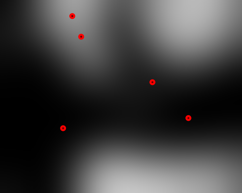

-1083.054747334737


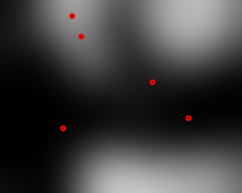

-1072.6134943213865


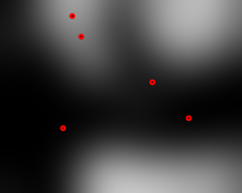

-1083.4219629690585


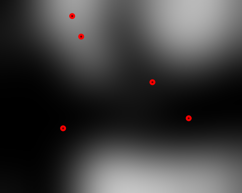

-1072.0792115665722


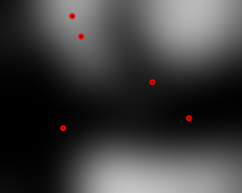

-1083.3706239893634


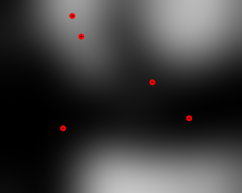

-1081.8590353822792


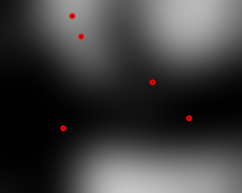

-1071.7647215910906


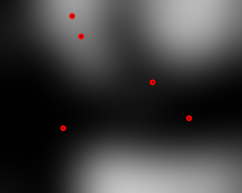

-1070.6290826754164


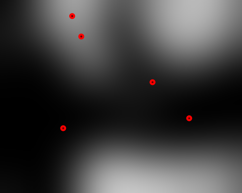

-1071.2015812260124


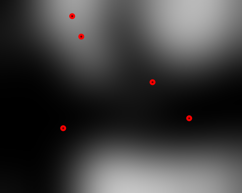

-1073.3833712475557


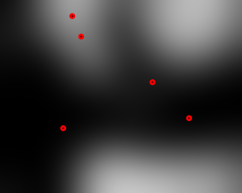

-1082.1289202174887


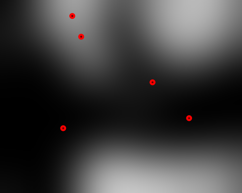

-1082.4694379052976


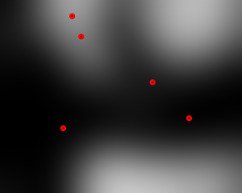

-1073.1303278755547


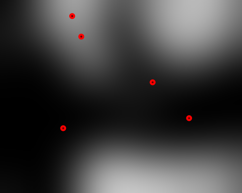

-1072.123727326109


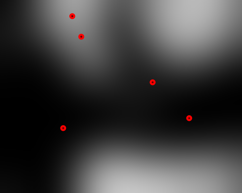

-1084.464725983609


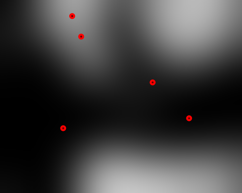

-1071.6701574356487


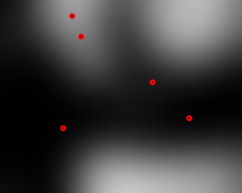

-1071.97088911377


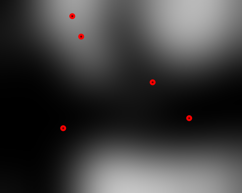

-1083.2573753050694


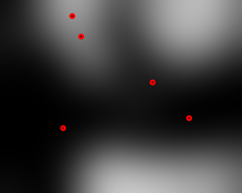

-1082.5219092214766


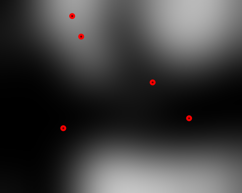

-1071.7247994299482


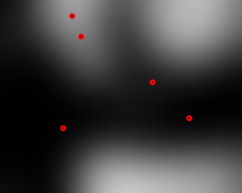

-1071.97088911377


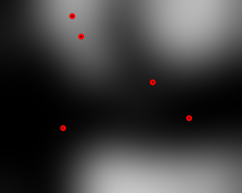

-1083.1747292024631


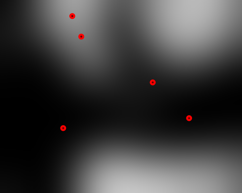

-1082.7906159557667


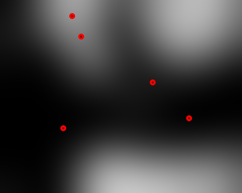

-1071.7262850502536


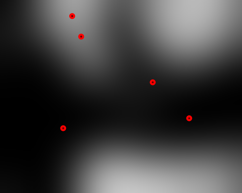

-1071.973026277404


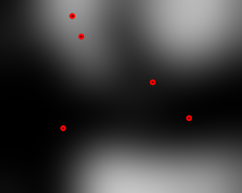

-1082.4020112583062
                       Summary 

----------------------[FACTORS]-----------------------



NameError: name '_drone_average' is not defined

In [78]:
solver._run_simulation(SolvingAlgorithm.ACCELERATED, 0)

In [ ]:

##for i in range(50):
##    columns = ['Accelerated Cost Metric']
##    data = {'Accelerated Cost Metric' : list(accelerated_cost_diagrams[i])}
##    for dr in range(solver.DRONE_NUMBER):
##        title = 'Accelerated Distance Metric | Drone ' + str (dr+1)
##        data[title] = list(accelerated_distance_diagrams[dr][i])
##        columns.append(title)
##
##    df = pd.DataFrame(data)
##    df.to_csv('../OUTPUT/output_accelerated_' + str(i + 1) + '.csv')
##    
##    columns = ['Classic Cost Metric']
##    data = {'Classic Cost Metric' : list(classic_cost_diagrams[i])}
##    for dr in range(solver.DRONE_NUMBER):
##        title = 'Classic Distance Metric | Drone ' + str (dr+1)
##        data[title] = list(classic_distance_diagrams[dr][i])
##        columns.append(title)
##
##    df = pd.DataFrame(data)
##    df.to_csv('../OUTPUT/output_classic_' + str(i + 1) + '.csv')
